#Informatyka w medycynie

##**Zadanie 1 - Tomograf**

Dominik Pawłowski 145289 \\
Bartłomiej Kowalewski 145204

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
import IPython.display
import pydicom as pd
from pydicom.dataset import FileDataset, FileMetaDataset, validate_file_meta
from pydicom.uid import UID, generate_uid
from ipywidgets import interact

In [ ]:
def circle_coords(angle_shift, angle_range, count, radius=1, center=(0, 0)):
    angles = np.linspace(0, angle_range, count) + angle_shift
    cx, cy = center
    x = radius * np.cos(angles) - cx
    y = radius * np.sin(angles) - cy
    points = np.array(list(zip(x, y)))
    return np.floor(points).astype(int)

def detector_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_coords(np.radians(alpha - angle_range/2), np.radians(angle_range), count, radius, center)

def emitter_coords(alpha, angle_range, count, radius=1, center=(0,0)):
    return circle_coords(np.radians(alpha - angle_range/2 + 180), np.radians(angle_range), count, radius, center)[::-1]

In [ ]:
def bresenham(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else 1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)
    if swapped:
        xs, ys = ys, xs
    return np.array([xs, ys])

In [ ]:
print(bresenham(2,2,-1,-1))

[[ 2  1  0 -1]
 [ 2  1  0 -1]]


In [ ]:
def draw_lines(emitters, detectors):
  lines = list()
  for (x0, y0), (x1, y1) in zip(emitters, detectors):
    lines.append(np.array(bresenham(x0, y0, x1, y1)))
  return lines

In [ ]:
number_of_scans = 360
number_of_detectors = 700
angle_range = 270

In [ ]:
def set_params(scans, detectors, angle):
  number_of_scans = scans
  number_of_detectors = detectors
  angle_range = angle

In [ ]:
interact(set_params, scans=(90,720,90), detectors=(90,720,90), angle=(45,270,45));

interactive(children=(IntSlider(value=360, description='scans', max=720, min=90, step=90), IntSlider(value=360…

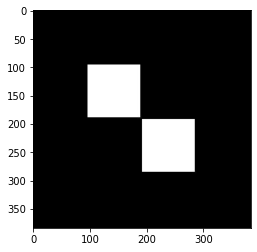

In [ ]:
image = cv2.imread('Kwadraty2.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray');

In [ ]:
def image_pad(array):
    w, h = array.shape
    side = int(np.ceil((w**2 + h**2)**0.5))
    shape = (side, side)
    pad = (np.array(shape) - np.array(array.shape)) / 2
    pad = np.array([np.floor(pad), np.ceil(pad)]).T.astype(int)
    return np.pad(array, pad)

def rescale(array):
    res = array.astype('float32')
    res -= np.min(res)
    res /= np.max(res)
    return res

def unpad(img, height, width):
    y,x = img.shape
    startx = x//2-(width//2)
    starty = y//2-(height//2)    
    return img[starty:starty+height,startx:startx+width]

In [ ]:
def radon(detector_count, angle_range, image, radius, center, alpha):
    emitters = emitter_coords(alpha, angle_range, detector_count, radius, center)
    detectors = detector_coords(alpha, angle_range, detector_count, radius, center)
    lines = draw_lines(emitters, detectors)
    result = rescale(np.array([np.sum(image[tuple(line)]) for line in lines]))
    return result

def radon_all(image, scan_count, detector_count, angle_range):
    image = image_pad(image)
    center = np.floor(np.array(image.shape) / 2).astype(int)
    width = height = image.shape[0]
    radius = width // 2
    alphas = np.linspace(0, 180, scan_count)
    results = np.zeros((scan_count, detector_count))
    
    plt.figure()
    for i, alpha in enumerate(alphas):
        results[i] = radon(detector_count, angle_range, image, radius, center, alpha)
        sins.append(np.copy(np.swapaxes(results,0,1)))
        plt.imshow(np.swapaxes(results,0,1), cmap=plt.cm.Greys_r)
        plt.show()
        IPython.display.clear_output(wait=True)
        
    return np.swapaxes(results,0,1)

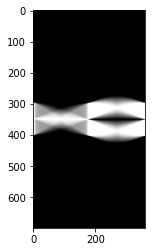

In [ ]:
sins = []
sinogram = radon_all(image, number_of_scans, number_of_detectors, angle_range)

In [ ]:
def plot_sinogram(i):
  plt.imshow(sins[i], cmap='gray');

In [ ]:
interact(plot_sinogram, i=(0,len(sins)-1));

interactive(children=(IntSlider(value=179, description='i', max=359), Output()), _dom_classes=('widget-interac…

In [ ]:
def inverse_radon(image, num_of_lines, single_alpha_sinogram, alpha, detector_count, angle_range, radius, center):
    emitters = emitter_coords(alpha, angle_range, detector_count, radius, center)
    detectors = detector_coords(alpha, angle_range, detector_count, radius, center)
    lines = draw_lines(emitters, detectors)
    for i, line in enumerate(lines):
        image[tuple(line)] += single_alpha_sinogram[i]
        num_of_lines[tuple(line)] += 1

def inverse_radon_all(shape, sinogram, angle_range, pad=True):
    number_of_detectors, number_of_scans = sinogram.shape
    sinogram = np.swapaxes(sinogram,0,1)
    
    result = np.zeros(shape)
    result = image_pad(result)
    num_of_lines = np.zeros(result.shape)
    
    center = np.floor(np.array(result.shape) / 2).astype(int)
    width = height = result.shape[0]
    radius = width // 2
    alphas = np.linspace(0, 180, number_of_scans)
    
    for i, alpha in enumerate(alphas):
        inverse_radon(result, num_of_lines, sinogram[i], alpha, number_of_detectors, angle_range, radius, center)
        out.append(np.copy(result))
        plt.imshow(result, cmap=plt.cm.Greys_r)
        plt.show()
        IPython.display.clear_output(wait=True)
    
    num_of_lines[num_of_lines == 0] = 1
    result = rescale(result / num_of_lines)
    out.append(np.copy(result))
    result = unpad(result, *shape)
    return result

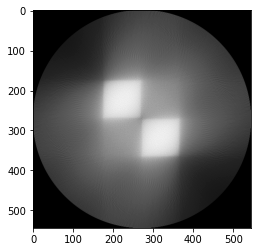

In [ ]:
out = []
output = inverse_radon_all(image.shape, sinogram, angle_range)

In [ ]:
def plot_inverse(i):
  plt.imshow(out[i], cmap="gray");

In [ ]:
interact(plot_inverse, i=(0,len(out)-1));

interactive(children=(IntSlider(value=180, description='i', max=360), Output()), _dom_classes=('widget-interac…

In [ ]:
def dicom_read(file):
  dicom = pd.dcmread(file)
  print(dicom)
  plt.imshow(np.array(dicom.pixel_array).astype(np.uint8), cmap='gray');
  #print(np.array(dicom.pixel_array))

def dicom_write(file, data):
  file_meta = FileMetaDataset()
  file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')
  file_meta.MediaStorageSOPInstanceUID = generate_uid()
  file_meta.ImplementationClassUID = generate_uid()
  file_meta.TransferSyntaxUID = UID('1.2.840.10008.1.2.1')

  ds = FileDataset(file, {}, file_meta=file_meta, preamble=b'\0'*128)
  ds.PatientName = data['name']
  ds.PatientID = data['id']
  ds.is_little_endian = True
  ds.is_implicit_VR = False
  ds.StudyDate = data['date'] #.strftime('%Y%m%d')

  ds.SeriesInstanceUID = generate_uid()
  ds.StudyInstanceUID = generate_uid()
  ds.FrameOfReferenceUID = generate_uid()

  ds.BitsStored = 8
  ds.BitsAllocated = 8
  ds.SamplesPerPixel = 1
  ds.HighBit = 7

  ds.ImagesInAcquisition = '1'
  ds.Rows = data['image'].shape[0]
  ds.Columns = data['image'].shape[1]
  ds.InstanceNumber = 1

  ds.ImageType = r'ORIGINAL\PRIMARY\AXIAL'

  ds.RescaleIntercept = '0'
  ds.RescaleSlope = '1'
  ds.PixelSpacing = r'1\1'
  ds.PhotometricInterpretation = 'MONOCHROME2'
  ds.PixelRepresentation = 0

  ds.ImageComments = data['comment']
  ds.PixelData = (data['image']).astype(np.uint8).tobytes()

  validate_file_meta(ds.file_meta, enforce_standard=True)

  ds.save_as(file, write_like_original=False)
  print('File created')
  dicom_read(file)

File created
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 242
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10984493111002762330123500459554154384
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.73325842500155751202387849159715647482
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0020) Study Date                          DA: '20220329'
(0010, 0010) Patient's Name                      PN: 'Example^Man'
(0010, 0020) Patient ID                          LO: '123'
(0020, 000d) Study Instance UID    

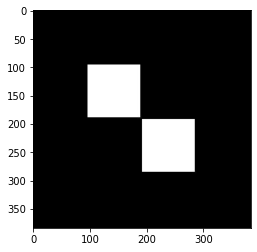

In [ ]:
#dicom_read('SADDLE_PE.dcm')

patient_data = {
    'name' : 'Example^Man',
    'id' : '123',
    'date' : '20220329',
    'image' : image,
    'comment' : 'Lorem Ipsum',
}

dicom_write('New.dcm', patient_data)